# Practice 3

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

In [1]:
import torch
import torchvision
import torchinfo
import numpy as np
from PIL import Image
import torch.nn as nn
import scipy.io as sio
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tf

/home/lukovsky/Documents/repos/DL-2024/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Google Drive (or not)

In [2]:
# Comment if not in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# datadir = '/content/drive/My Drive/DeepLearning_2024/P3/Data/'
datadir = 'Data/'

# resultsdir = '/content/drive/My Drive/DeepLearning_2024/P3/Results/'
resultsdir = 'Results/'

# GPU Acceleration (or not)

In [3]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Label: 1


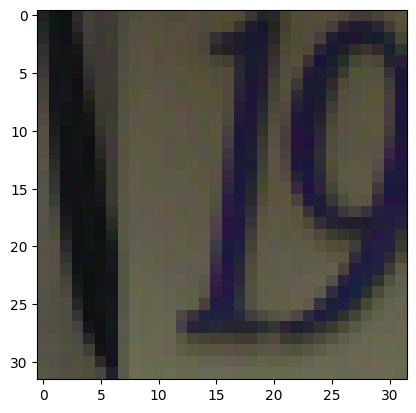

In [4]:
train_mat = sio.loadmat(datadir + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,0], labels[0]

print('Label: ' + str(example_label))
plt.imshow(example_image)
plt.show()

# Ex. 1


1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples. You can explore different strategies:
    - 1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
    - 1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
    - 1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
    - 1.4 Whatever you consider...

2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.

# Sol. 1

In [5]:
#Data Loader
class SVHN(torch.utils.data.Dataset):

    def __init__(self, dataDir = datadir + 'svhn/train_32x32.mat', transform = None):
        mat = sio.loadmat(dataDir)
        self.data, self.labels = mat['X'], mat['y'].squeeze()
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]

        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

    def __len__(self):
        return len(self.data)

In [6]:
def mean_std(dataDir= datadir + 'svhn/train_32x32.mat'):
    mat = sio.loadmat(dataDir)
    data = mat['X']
    return data.mean(axis=(0,1,3)), data.std(axis=(0,1,3))

In [7]:
SHVN_mean, SHVN_std = mean_std()
print(SHVN_mean)

tr = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(mean = SHVN_mean, std = SHVN_std)
])

# Define an standard CNN -> Two conv. blocks and linear layer
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3

        self.fc = nn.Linear(8*8*32, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)

        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1) #128,32,28,28 -> 128,28*28*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

[111.60893668 113.16127466 120.56512767]


In [8]:
CNN = ConvNet()
CNN = CNN.to(device)

In [9]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

In [10]:
# Load train and test datasets
SVHNTrain = SVHN(datadir + 'svhn/train_32x32.mat', tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                            batch_size=256,
                                            shuffle=True)

SVHNTest = SVHN(datadir + 'svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                            batch_size=256,
                                            shuffle=True)

In [11]:
# Train the model
CNN.train() # Set the model in train mode
total_step = len(train_loader)
# Iterate over epochs
for epoch in range(num_epochs):
    # Iterate the dataset/batches
    for i, (images, labels) in enumerate(train_loader):
        # Get batch of samples and labels
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = CNN(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Save the model checkpoint
torch.save(CNN.state_dict(), resultsdir+'model.ckpt')
#to load : model.load_state_dict(torch.load(save_name_ori))

In [12]:
#Load the model
CNN.load_state_dict(torch.load(resultsdir+'model.ckpt'))

# Test the model
CNN.eval() # Set the model in evaluation mode

# Compute testing accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # get network predictions
        outputs = CNN(images)

        # get predicted class
        _, predicted = torch.max(outputs.data, 1)

        # compare with the ground-truth
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 12.5 %


### **Testing**


#### Number of convolution layers and number of filters (channels)

In [13]:
#Increasing size of network (one more conv layer)

class TestingConvNet(nn.Module):
    def __init__(self, num_classes=10):

        super(TestingConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5,  padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5,  padding=2) #layer added
        self.fc = nn.Linear(4*4*128, num_classes) #fully connected layer modified

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        return out

In [14]:
CNN = TestingConvNet()
CNN = CNN.to(device)

# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

num_epochs = 5

In [15]:
# Train the model
CNN.train() # Set the model in train mode
total_step = len(train_loader)
# Iterate over epochs
for epoch in range(num_epochs):
    # Iterate the dataset/batches
    for i, (images, labels) in enumerate(train_loader):
        # Get batch of samples and labels
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = CNN(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Save the model checkpoint
torch.save(CNN.state_dict(), resultsdir+'model.ckpt')
#to load : model.load_state_dict(torch.load(save_name_ori))

In [16]:
#Load the model
CNN.load_state_dict(torch.load(resultsdir+'model.ckpt'))

# Test the model
CNN.eval() # Set the model in evaluation mode

# Compute testing accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # get network predictions
        outputs = CNN(images)

        # get predicted class
        _, predicted = torch.max(outputs.data, 1)

        # compare with the ground-truth
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 12.5 %


#### Optimizers

In [17]:
CNN = ConvNet()
CNN = CNN.to(device)

criterion = nn.CrossEntropyLoss()

optimizers = [(torch.optim.Adam(CNN.parameters(),lr = .001), "Adam"),
              (torch.optim.SGD(CNN.parameters(), lr = .001, momentum = 0.9), "SGD")]

num_epochs = 5

In [18]:
for optimizer, label in optimizers:

    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset/batches
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Save the model checkpoint
    torch.save(CNN.state_dict(), resultsdir+'model.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))

    #Load the model
    CNN.load_state_dict(torch.load(resultsdir+'model.ckpt'))

    # Test the model
    CNN.eval() # Set the model in evaluation mode

    # Compute testing accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model with optimizer {}: {} %'.format(label, 100 * correct / total))

Test Accuracy of the model with optimizer Adam: 12.5 %
Test Accuracy of the model with optimizer SGD: 12.5 %


#### Learning rate


In [19]:
learning_rates = [.01, .05, .001, .005, .0001]

In [20]:
for lr in learning_rates:

    optimizer = torch.optim.Adam(CNN.parameters(),lr = lr)

    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset/batches
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Save the model checkpoint
    torch.save(CNN.state_dict(), resultsdir+'model.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))

    #Load the model
    CNN.load_state_dict(torch.load(resultsdir+'model.ckpt'))

    # Test the model
    CNN.eval() # Set the model in evaluation mode

    # Compute testing accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model with learning rate {}: {} %'.format(lr, 100 * correct / total))

Test Accuracy of the model with learning rate 0.01: 12.5 %
Test Accuracy of the model with learning rate 0.05: 12.5 %
Test Accuracy of the model with learning rate 0.001: 12.5 %
Test Accuracy of the model with learning rate 0.005: 12.5 %
Test Accuracy of the model with learning rate 0.0001: 12.5 %


# Ex. 2

## **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [21]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [22]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


'\n1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.\n  - MobileNet: https://arxiv.org/abs/1704.04861\n  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf\n  - SqueezeNet: https://arxiv.org/abs/1602.07360\n  - ShuffleNet: https://arxiv.org/abs/1707.01083\n  - ESPNet V2: https://arxiv.org/abs/1811.11431\n2. Train it and test it on SVHN using the provided code.\n3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.\n'

# Sol. 2

## Define your own model and check the number of total parameters

In [23]:
# https://github.com/xin-w8023/SqueezeNet-PyTorch/blob/master/fire.py

class Expand(torch.nn.Module):
    def __init__(self, in_channels, e1_out_channles, e3_out_channles):
        super(Expand, self).__init__()
        self.conv_1x1 = torch.nn.Conv2d(in_channels, e1_out_channles, (1, 1))
        self.conv_3x3 = torch.nn.Conv2d(in_channels, e3_out_channles, (3, 3), padding=1)

    def forward(self, x):
        o1 = self.conv_1x1(x)
        o3 = self.conv_3x3(x)
        return torch.cat((o1, o3), dim=1)


class Fire(torch.nn.Module):
    """
      Fire module in SqueezeNet
      out_channles = e1x1 + e3x3
      Eg.: input: ?xin_channelsx?x?
           output: ?x(e1x1+e3x3)x?x?
    """
    def __init__(self, in_channels, s1x1, e1x1, e3x3):
        super(Fire, self).__init__()

        # squeeze 
        self.squeeze = torch.nn.Conv2d(in_channels, s1x1, (1, 1))
        self.sq_act = torch.nn.LeakyReLU(0.1)

        # expand
        self.expand = Expand(s1x1, e1x1, e3x3)
        self.ex_act = torch.nn.LeakyReLU(0.1)
        

    def forward(self, x):
        x = self.sq_act(self.squeeze(x))
        x = self.ex_act(self.expand(x))
        return x

In [108]:
# ESPNet V2 Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):

        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire1 = Fire(8, 4, 8, 8)
        self.fire2 = Fire(16, 8, 8, 8)
        self.fire3 = Fire(16, 8, 16, 16)
        self.fire4 = Fire(32, 16, 32, 32)
        self.fc = nn.Linear(64*8*8, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)

        out = self.fire1(out)
        out = self.fire2(out)
        out = self.maxpool(out)

        out = self.fire3(out)
        out = self.fire4(out)
        out = self.maxpool(out)
        
        out = self.fc(out.view(out.shape[0], -1))
        return out

model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))

MyModel Parameters: 49518


In [110]:
torchinfo.summary(model, (32, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [32, 10]                  --
├─Conv2d: 1-1                            [32, 8, 32, 32]           224
├─ReLU: 1-2                              [32, 8, 32, 32]           --
├─Fire: 1-3                              [32, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 4, 32, 32]           36
│    └─LeakyReLU: 2-2                    [32, 4, 32, 32]           --
│    └─Expand: 2-3                       [32, 16, 32, 32]          --
│    │    └─Conv2d: 3-1                  [32, 8, 32, 32]           40
│    │    └─Conv2d: 3-2                  [32, 8, 32, 32]           296
│    └─LeakyReLU: 2-4                    [32, 16, 32, 32]          --
├─Fire: 1-4                              [32, 16, 32, 32]          --
│    └─Conv2d: 2-5                       [32, 8, 32, 32]           136
│    └─LeakyReLU: 2-6                    [32, 8, 32, 32]           --
│    └─Expan

## Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [111]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.to(device).item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), resultsdir+ '/' + model_name)

    return losses_list

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [112]:
#Train MyModel
my_model = MyModel()

#Initialize optimizer
learning_rate = .01
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate,
                            weight_decay=1e-5, momentum=0.9)

my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=200, model_name='my_net.ckpt', device=device)

Epoch [1/200], Step [1/1], Loss: 2.3049
Epoch [2/200], Step [1/1], Loss: 2.2957
Epoch [3/200], Step [1/1], Loss: 2.2791
Epoch [4/200], Step [1/1], Loss: 2.2569
Epoch [5/200], Step [1/1], Loss: 2.2314
Epoch [6/200], Step [1/1], Loss: 2.2045
Epoch [7/200], Step [1/1], Loss: 2.1781
Epoch [8/200], Step [1/1], Loss: 2.1538
Epoch [9/200], Step [1/1], Loss: 2.1328
Epoch [10/200], Step [1/1], Loss: 2.1161
Epoch [11/200], Step [1/1], Loss: 2.1042
Epoch [12/200], Step [1/1], Loss: 2.0970
Epoch [13/200], Step [1/1], Loss: 2.0938
Epoch [14/200], Step [1/1], Loss: 2.0934
Epoch [15/200], Step [1/1], Loss: 2.0942
Epoch [16/200], Step [1/1], Loss: 2.0950
Epoch [17/200], Step [1/1], Loss: 2.0947
Epoch [18/200], Step [1/1], Loss: 2.0930
Epoch [19/200], Step [1/1], Loss: 2.0900
Epoch [20/200], Step [1/1], Loss: 2.0863
Epoch [21/200], Step [1/1], Loss: 2.0824
Epoch [22/200], Step [1/1], Loss: 2.0787
Epoch [23/200], Step [1/1], Loss: 2.0756
Epoch [24/200], Step [1/1], Loss: 2.0733
Epoch [25/200], Step [1/1

## Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [67]:
# Show results for all the trained models
SVHNTest = SVHN(datadir+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256,
                                               shuffle=True)

#
my_net = MyModel()
my_net.load_state_dict(torch.load(resultsdir + 'my_net.ckpt'))
my_net.to(device)
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 12.5


# Ex. 3

In [29]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results.
'''

'\n1. Use the implemented architecture in the previous exercice to solve the transfer learning\n   task provided in the examples.\n2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.\n2. Report the test accuracy in each case and discuss the results.\n'

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [30]:
# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(datadir+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256,
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(datadir+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64,
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(datadir+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64,
                                                  shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [31]:
#Train ResNet
resnet_tl = MyModel(num_classes=8)
#Initialize optimizer
learning_rate = .1
optimizer = torch.optim.SGD(resnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)

IndexError: Target 8 is out of bounds.

### Fine-tune the pretrained network with the small dataset of 9s and 0s